# First look at the data
*2019-11-15*

*Goal:* The goal of this notebook is to get a basic idea about the data.

## Imports and Utils

In [1]:
from itertools import chain

from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
Path.ls = property(lambda path: sorted(list(path.iterdir())))


import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import functional as TF

from wssseg.torch_utils import DEVICE, imagenet_stats

%matplotlib inline

# Analysis

## Look at the dataset

In [2]:
mask_path = Path("../data/raw/ground_truth/")
mask_path.ls

[PosixPath('../data/raw/ground_truth/top_mosaic_09cm_area1.tif'),
 PosixPath('../data/raw/ground_truth/top_mosaic_09cm_area10.tif'),
 PosixPath('../data/raw/ground_truth/top_mosaic_09cm_area11.tif'),
 PosixPath('../data/raw/ground_truth/top_mosaic_09cm_area12.tif'),
 PosixPath('../data/raw/ground_truth/top_mosaic_09cm_area13.tif'),
 PosixPath('../data/raw/ground_truth/top_mosaic_09cm_area14.tif'),
 PosixPath('../data/raw/ground_truth/top_mosaic_09cm_area15.tif'),
 PosixPath('../data/raw/ground_truth/top_mosaic_09cm_area16.tif'),
 PosixPath('../data/raw/ground_truth/top_mosaic_09cm_area17.tif'),
 PosixPath('../data/raw/ground_truth/top_mosaic_09cm_area2.tif'),
 PosixPath('../data/raw/ground_truth/top_mosaic_09cm_area20.tif'),
 PosixPath('../data/raw/ground_truth/top_mosaic_09cm_area21.tif'),
 PosixPath('../data/raw/ground_truth/top_mosaic_09cm_area22.tif'),
 PosixPath('../data/raw/ground_truth/top_mosaic_09cm_area23.tif'),
 PosixPath('../data/raw/ground_truth/top_mosaic_09cm_area24.tif'

In [3]:
img_path = Path("../data/raw/top/")
img_path.ls

[PosixPath('../data/raw/top/top_mosaic_09cm_area1.tif'),
 PosixPath('../data/raw/top/top_mosaic_09cm_area10.tif'),
 PosixPath('../data/raw/top/top_mosaic_09cm_area11.tif'),
 PosixPath('../data/raw/top/top_mosaic_09cm_area12.tif'),
 PosixPath('../data/raw/top/top_mosaic_09cm_area13.tif'),
 PosixPath('../data/raw/top/top_mosaic_09cm_area14.tif'),
 PosixPath('../data/raw/top/top_mosaic_09cm_area15.tif'),
 PosixPath('../data/raw/top/top_mosaic_09cm_area16.tif'),
 PosixPath('../data/raw/top/top_mosaic_09cm_area17.tif'),
 PosixPath('../data/raw/top/top_mosaic_09cm_area2.tif'),
 PosixPath('../data/raw/top/top_mosaic_09cm_area20.tif'),
 PosixPath('../data/raw/top/top_mosaic_09cm_area21.tif'),
 PosixPath('../data/raw/top/top_mosaic_09cm_area22.tif'),
 PosixPath('../data/raw/top/top_mosaic_09cm_area23.tif'),
 PosixPath('../data/raw/top/top_mosaic_09cm_area24.tif'),
 PosixPath('../data/raw/top/top_mosaic_09cm_area26.tif'),
 PosixPath('../data/raw/top/top_mosaic_09cm_area27.tif'),
 PosixPath('../d

In [4]:
# make sure we have the 33 images
assert len(img_path.ls) == 33
assert len(mask_path.ls) == 33
# make sure there are matching names in list of masks and list of images
assert set([p.name.split("_")[-1] for p in img_path.ls]) == set([p.name.split("_")[-1] for p in mask_path.ls])

In [5]:
# make sure we can open all images
for p in chain(img_path.ls, mask_path.ls):
    try:
        _tmp = Image.open(str(p))
    except Exception as e:
        print(f"Problems opening {f}")
        print(e)

In [6]:
img = Image.open(img_path.ls[0])
print(img.size)
img.resize((300, 300))

(1919, 2569)


(1919, 2569)


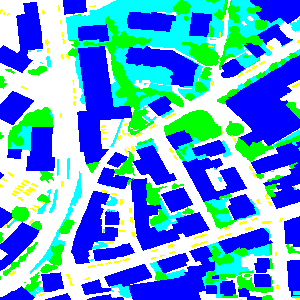

In [7]:
img = Image.open(mask_path.ls[0])
print(img.size)
img.resize((300, 300))

## Dataset

In [8]:
from torchvision.datasets import VisionDataset
from typing import Sequence, List

In [9]:
class VaihingenSegmentationDataset(VisionDataset):
    def __init__(self, images: Sequence, masks: Sequence, transforms=None):
        assert len(images) == len(masks)
        assert set([p.name.split("_")[-1] for p in images]) == set([p.name.split("_")[-1] for p in masks])
        
        super().__init__(root=None, transforms=transforms)
        self.images = images
        self.masks = masks
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert("RGB")
        target = Image.open(self.masks[index]).convert("L")

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

In [10]:
ds = VaihingenSegmentationDataset(img_path.ls, mask_path.ls)

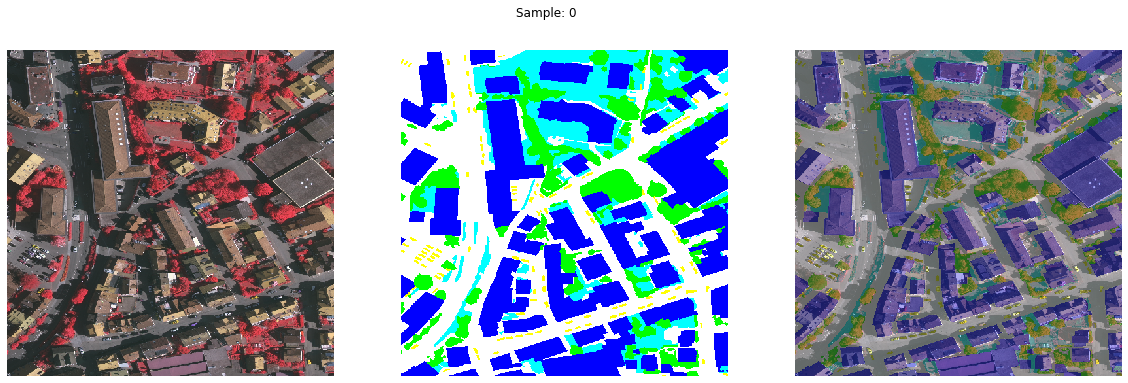

In [11]:
def show_sample(ds, idx, size=500, figsize=(20, 6)):
    size = size, size
    img = Image.open(ds.images[idx]).resize(size)
    mask = Image.open(ds.masks[idx]).resize(size)
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    axes[0].imshow(img)
    axes[1].imshow(mask)
    axes[2].imshow(img)
    axes[2].imshow(mask, alpha=0.3)
    
    fig.suptitle(f"Sample: {idx}")
    for ax in axes:
        ax.axis("off")

        
VaihingenSegmentationDataset.show_sample = show_sample
ds.show_sample(0)

In [12]:
ds.show_sample(6)

## Transforms

How do the default transforms look like for our dataset.

In [13]:
from wssseg.torchseg import transforms as T
from typing import Callable

In [14]:
import numpy as np

In [15]:
# Taken https://github.com/pytorch/vision/tree/master/references/segmentation

def get_transform(train: bool) -> Callable:
    base_size = 520
    crop_size = 480

    min_size = int((0.5 if train else 1.0) * base_size)
    max_size = int((2.0 if train else 1.0) * base_size)
    transforms = []
    transforms.append(T.RandomResize(min_size, max_size))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomCrop(crop_size))
    transforms.append(T.ToTensor())
    transforms.append(T.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]))

    return T.Compose(transforms)

In [16]:
ds = VaihingenSegmentationDataset(img_path.ls, mask_path.ls, transforms=get_transform(train=True))

In [17]:
ds[0][0].shape, ds[0][1].shape

(torch.Size([3, 480, 480]), torch.Size([480, 480]))

In [18]:
ds[0][1]

tensor([[178, 178, 178,  ..., 255, 255, 255],
        [178, 178, 178,  ..., 255, 255, 255],
        [178, 178, 178,  ..., 255, 255, 255],
        ...,
        [178, 178, 178,  ..., 255, 255, 255],
        [ 29,  29,  29,  ..., 255, 255, 255],
        [ 29,  29,  29,  ..., 255, 255, 255]])

In [19]:
ds[0][1].unique(return_counts=True)

(tensor([ 29, 149, 178, 225, 255]),
 tensor([85084, 28475, 18532,  4608, 93701]))

In [20]:
img, mask = ds[2]
plt.imshow(img.permute(1, 2, 0))
plt.imshow(mask, alpha=0.5)
plt.axis("off")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 479.5, 479.5, -0.5)